In [1]:
using Turing
using LimberJack
using CSV
using NPZ
using Plots
using FITSIO
using Plots
using LinearAlgebra
using Distributed

In [2]:
files = npzread("../data/DESY1_cls/Cls_meta.npz")
Cls_meta = cls_meta(files)

cls_meta{Vector{Vector{Int64}}}([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3]], [[1, 0, 1, 0], [1, 1, 1, 1], [1, 2, 1, 2], [1, 3, 1, 3], [1, 4, 1, 4], [1, 0, 2, 0], [1, 0, 2, 1], [1, 0, 2, 2], [1, 0, 2, 3], [1, 1, 2, 0]  …  [2, 0, 2, 0], [2, 0, 2, 1], [2, 0, 2, 2], [2, 0, 2, 3], [2, 1, 2, 1], [2, 1, 2, 2], [2, 1, 2, 3], [2, 2, 2, 2], [2, 2, 2, 3], [2, 3, 2, 3]], [[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 6]  …  [6, 6], [6, 7], [6, 8], [6, 9], [7, 7], [7, 8], [7, 9], [8, 8], [8, 9], [9, 9]])

In [3]:
cov_tot = files["cov"]
data_vector = files["cls"]

475-element Vector{Float64}:
  0.00019024248750512107
  7.391276663994371e-5
  4.261252890607883e-5
  2.22965965139283e-5
  2.176880112868429e-5
  8.240734039668606e-5
  8.421314587773898e-5
  2.6585137640401017e-5
  2.6033426315289483e-5
  1.6202481595102046e-5
  1.3310988829992239e-5
  1.0699346577168782e-5
  7.686133839717875e-6
  ⋮
 -1.6863476005400308e-10
  3.715784037645668e-10
  4.737458899576856e-10
  8.27594560926968e-10
  5.318332277673948e-10
  3.860067333751191e-10
  4.674884118894536e-10
  3.737344096265107e-10
  8.676072775051082e-11
  2.8609099937088954e-10
  2.0381853638647756e-10
  1.2493271614464064e-10

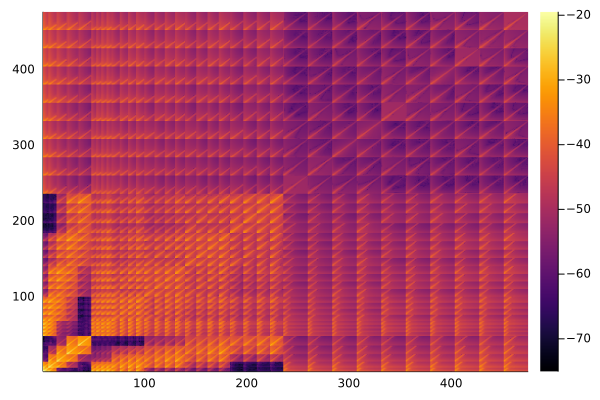

In [4]:
heatmap(1:size(cov_tot,1), 1:size(cov_tot,2), log.((cov_tot.^2).^0.5))

In [8]:
writecsv()

LoadError: UndefVarError: writecsv not defined

In [6]:
@model function model(data_vector; cov_tot=cov_tot)
    Ωm ~ Uniform(0.2, 0.3)
    h ~ Uniform(0.6, 0.8)
    s8 ~ Uniform(0.7, 1.0)
    
    b0 ~ Uniform(1.0, 3.0)
    b1 ~ Uniform(1.0, 3.0)
    b2 ~ Uniform(1.0, 3.0)
    b3 ~ Uniform(1.0, 3.0)
    b4 ~ Uniform(1.0, 3.0)
    
    nuisances = Dict("b0" => b0,
                     "b1" => b1,
                     "b2" => b2,
                     "b3" => b3,
                     "b4" => b4)
    
    cosmology = LimberJack.Cosmology(Ωm, 0.05, h, 0.96, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, nuisances, Cls_meta, files)
    data_vector ~ MvNormal(theory, cov_tot)
end;

iterations = 10

# Start sampling.
folname = string("DES_full_test_", "MH")
if isdir(folname)
    println("Folder already exists")
    if isfile(joinpath(folname, "chain.jls"))
        println("Restarting from past chain")
        past_chain = read(joinpath(folname, "chain.jls"), Chains)
        new_chain = sample(model(data_vector), MH(), iterations,
                           progress=true; save_state=true, resume_from=past_chain)
        vcat(CSV.read.(file_names)...) |> CSV.write("one_big_file.csv")
    else
        new_chain = sample(model(data_vector), MH(), iterations,
                    progress=true; save_state=true)
        CSV.write(joinpath(folname, "chain.csv"), new_chain)
    end
else
    mkdir(folname)
    println("Created new folder")
    new_chain = sample(model(data_vector), MH(),
                iterations, progress=true; save_state=true)
    CSV.write(joinpath(folname, "chain.csv"), new_chain)
end

summary = describe(new_chain)[1]
CSV.write(joinpath(folname, "summary.csv"), summary)
write(joinpath(folname, "chain.jls"), new_chain)



Sampling: 100%|█████████████████████████████████████████| Time: 0:00:22


Folder already exists
Restarting from past chain


LoadError: ArgumentError: write failed, IOStream is not writeable

In [6]:
@model function model(data_vector; cov_tot=cov_tot)
    Ωm ~ Uniform(0.2, 0.3)
    h ~ Uniform(0.6, 0.8)
    s8 ~ Uniform(0.7, 1.0)
    
    b0 ~ Uniform(1.0, 3.0)
    b1 ~ Uniform(1.0, 3.0)
    b2 ~ Uniform(1.0, 3.0)
    b3 ~ Uniform(1.0, 3.0)
    b4 ~ Uniform(1.0, 3.0)
    
    nuisances = Dict("b0" => b0,
                     "b1" => b1,
                     "b2" => b2,
                     "b3" => b3,
                     "b4" => b4)
    
    cosmology = LimberJack.Cosmology(Ωm, 0.05, h, 0.96, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, nuisances, Cls_meta, files)
    data_vector ~ MvNormal(theory, cov_tot)
end;

iterations = 10
step_size = 0.005
samples_per_step = 5
cores = 4

# Start sampling.
folname = string("DES_full_test_", "stpsz_", step_size, "_smpls_", samples_per_step)
if isdir(folname)
    println("Folder already exists")
    if isfile(joinpath(folname, "chain.jls"))
        println("Restarting from past chain")
        past_chain = read(joinpath(folname, "chain.jls"), Chains)
        new_chain = sample(model(data_vector), HMC(step_size, samples_per_step), iterations,
                           progress=true; save_state=true, resume_from=past_chain)
    else
        new_chain = sample(model(data_vector), HMC(step_size, samples_per_step),
                    iterations, progress=true; save_state=true)
    end
else
    mkdir(folname)
    println("Created new folder")
    new_chain = sample(model(data_vector), HMC(step_size, samples_per_step),
                iterations, progress=true; save_state=true)
end

summary = describe(new_chain)[1]
fname_summary = string("summary.csv")
CSV.write(joinpath(folname, fname_summary), summary)

fname_jls = string("chain.jls")
write(joinpath(folname, fname_jls), new_chain)
    
fname_csv = string("chain.csv")
CSV.write(joinpath(folname, fname_csv), new_chain)



Sampling: 100%|█████████████████████████████████████████| Time: 0:03:53


Created new folder


"DES_full_test_stpsz_0.005_smpls_5/chain.csv"

In [7]:
# 2.3 s per evaluation in MH

In [8]:
# 3.6 s per evaluation HMC